In [30]:
%cd /home/artur/PycharmProjects/SegFormer_UVI

import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
from transformers import SegformerForSemanticSegmentation

from src.config import CFG
from src.dataset import get_csv_dataset, preprocess_mask
from src.image_transforms import get_transforms

data_path = f"{CFG.DATA_DIR}/uavid_train/seq1"
df = get_csv_dataset(data_path)

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.1, shuffle=True)
train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)


id2label = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}
label2id = {v: k for k, v in id2label.items()}

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",
    num_labels=8,
    id2label=id2label,
    label2id=label2id,
);
model.load_state_dict(torch.load("/home/artur/PycharmProjects/SegFormer_UVI/models/base_train.pt"))

/home/artur/PycharmProjects/SegFormer_UVI


Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.weight', 'decode_head.linear_c.3

<All keys matched successfully>

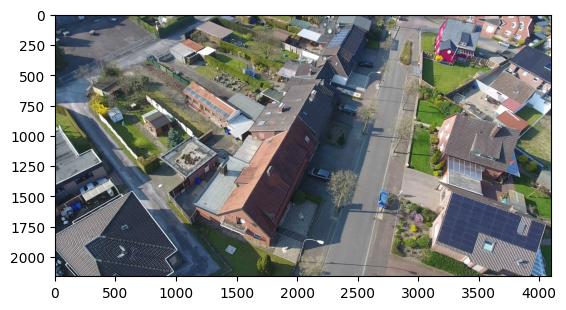

In [96]:
im_path = val_df.loc[24, 'images_paths']
image = cv2.imread(im_path, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
im_shape = image.shape
plt.imshow(image)

In [92]:
# forward pass
transforms = get_transforms(train=False)
image = transforms(image=image)["image"].unsqueeze(0)

outputs = model(pixel_values=image.type(torch.float32))

logits = outputs.logits.cpu()
upsampled_logits = nn.functional.interpolate(logits,
                size=im_shape[:2], # (height, width)
                mode='bilinear',
                align_corners=False)
seg = upsampled_logits.argmax(dim=1)[0]

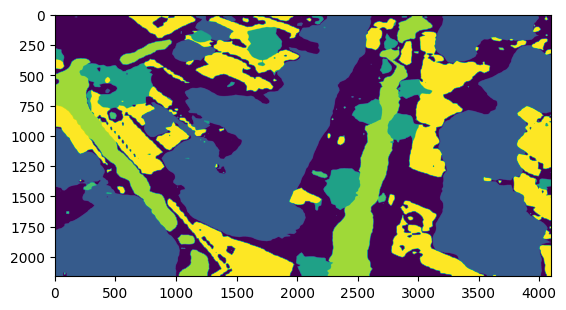

In [93]:
plt.imshow(seg)

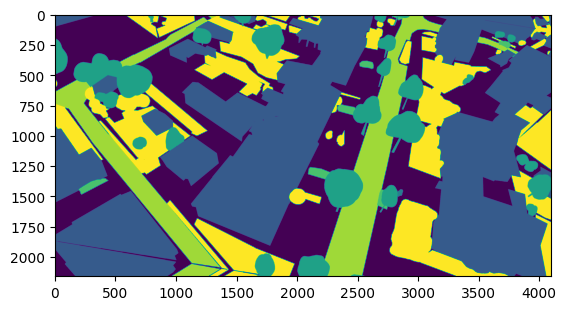

In [95]:
im_path = val_df.loc[24, 'masks_paths']
mask = cv2.imread(im_path, cv2.IMREAD_COLOR)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
mask = preprocess_mask(mask)
plt.imshow(mask)

In [98]:
import transformers
transformers.__version__

'4.24.0'